# Deep Policy-based Reinforcement Learning

<img src="https://github.com/jeremiedecock/polytechnique-inf639-2024-students/blob/main/assets/logo.jpg?raw=true" style="float: left; width: 15%" />

[CSC_53439_EP-2024](https://moodle.polytechnique.fr/course/view.php?id=19358) Lab session #2

2019-2024 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-inf639-2024-students/blob/main/lab2_deep_policy-based_reinforcement_learning.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf639-2024-students/main?filepath=lab2_deep_policy-based_reinforcement_learning.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-inf639-2024-students/blob/main/lab2_deep_policy-based_reinforcement_learning.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-inf639-2024-students/raw/main/lab2_deep_policy-based_reinforcement_learning.ipynb)

## Introduction

The aim of this lab is to provide an in-depth exploration of policy-based reinforcement learning techniques, with a particular focus on the *Monte Carlo Policy Gradient (REINFORCE)* and *Actor Critic* methods.

In this Python notebook, you'll have the opportunity to implement and assess several renowned Policy Gradient techniques.

You can either:
- open, edit and execute the notebook in *Google Colab* following this link: https://colab.research.google.com/github/jeremiedecock/polytechnique-inf639-2024-students/blob/main/lab2_deep_policy-based_reinforcement_learning.ipynb ; this is the **recommended** choice as you have nothing to install on your computer
- open, edit and execute the notebook in *MyBinder* (if for any reason the Google Colab solution doesn't work): https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf639-2024-students/main?filepath=lab2_deep_policy-based_reinforcement_learning.ipynb
- download, edit and execute the notebook on your computer if Python3 and JypyterLab are already installed: https://github.com/jeremiedecock/polytechnique-inf639-2024-students/raw/main/lab2_deep_policy-based_reinforcement_learning.ipynb

If you work with Google Colab or MyBinder, **remember to save or download your work regularly or you may lose it!**

## Setup the Python environment

This notebook relies on several libraries including `torch`, `gymnasium`, `numpy`, `pandas`, `seaborn`, `imageio`, `pygame`, and `tqdm`.
A complete list of dependencies can be found in the provided [requirements-minimal.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2024-students/main/requirements-minimal.txt) and [requirements.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2024-students/main/requirements.txt) files.

- [requirements-minimal.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2024-students/main/requirements.txt) contains the minimal dependencies required to run this notebook without the optional sections.
- [requirements.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2024-students/main/requirements.txt) contains all the dependencies required to run this notebook with all the optional sections.

### If you use Google Colab

If you use Google Colab, execute the next cell to install required libraries.

In [26]:
import sys, subprocess

def is_colab():
    return "google.colab" in sys.modules

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if is_colab():
    run_subprocess_command("apt install xvfb x11-utils")
    run_subprocess_command("pip install -r https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2024-students/main/requirements-lab2-google-colab.txt")

In [27]:
#! apt install xvfb x11-utils && pip install gymnasium pyvirtualdisplay

### If you have downloaded the notebook on your computer and execute it in your own Python environment

To set up the necessary dependencies, first download the [requirements.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2024-students/main/requirements.txt) or [requirements-minimal.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf639-2024-students/main/requirements-minimal.txt) depending on whether you want to run the optional sections of this notebook or not (c.f. *Setup the Python environment* section above).

Ensure it is located in the same directory as this notebook. Next, run the following command to establish a [Python virtual environment (venv)](https://docs.python.org/3/library/venv.html) that includes all the essential libraries for this lab.

#### On Posix systems (Linux, MacOSX, WSL, ...)

```bash
python3 -m venv env
source env/bin/activate
python3 -m pip install --upgrade pip
python3 -m pip install -r requirements.txt
```

Adapt the name of the requirements file if you have chosen to use the minimal version.

#### On Windows

```bash
python3 -m venv env
env\Scripts\activate.bat
python3 -m pip install --upgrade pip
python3 -m pip install -r requirements.txt
```

Adapt the name of the requirements file if you have chosen to use the minimal version.

### Run notebooks locally in a dedicated Docker container

If you are familiar with Docker, an image is available on Docker Hub for this lab:

```bash
docker run -it --rm -p 8888:8888 -v "${PWD}":/home/jovyan/work jdhp/inf639-lab2:latest
```

If you encounter an error during the notebook's execution indicating that writing a file is not possible, this issue may stem from the user ID within the container lacking the necessary permissions in the project directory. This problem can be resolved by modifying the directory's permissions, for example, using the command:

```bash
chmod 777 . figs models
rm -rf figs/*.gif
rm -rf figs/*.png
rm -rf models/*.pth
```

### Import required packages

In [28]:
import collections
from dataclasses import dataclass
import gymnasium as gym
import itertools
from IPython.display import Video
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from pathlib import Path
import random
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import sys
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Tuple, Deque, Optional, Callable
import warnings

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    # from tensorboardX import SummaryWriter
    warnings.warn("tensorboard is not installed")

try:
    import wandb
    # wandb.login()
except:
    warnings.warn("Wandb is not installed")
# from inf639 import *

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm

In [30]:
gym.__version__

'0.29.1'

In [31]:
sns.set_context("talk")

In [32]:
FIGS_DIR = Path("figs/")       # Where to save figures (.gif files)
PLOTS_DIR = Path("figs/")      # Where to save plots (.png or .svg files)
MODELS_DIR = Path("models/")   # Where to save models (.pth files)
LOGS_DIR = Path("logs/")       # Where to save logs

In [33]:
if not FIGS_DIR.exists():
    FIGS_DIR.mkdir()
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir()
if not MODELS_DIR.exists():
    MODELS_DIR.mkdir()
if not LOGS_DIR.exists():
    LOGS_DIR.mkdir()

### Create a Gymnasium rendering wrapper to visualize environments as GIF images within the notebook

This notebook allows you to visualize the episodes as animated GIFs. Run the cell below to enable this feature.

In [34]:
# To display GIF images in the notebook

import imageio     # To render episodes in GIF images (otherwise there would be no render on Google Colab)
                   # C.f. https://stable-baselines.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent
import IPython
from IPython.display import Image

#if is_colab():
#    import pyvirtualdisplay
#
#    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
#                                        size=(1400, 900))
#    _ = _display.start()

class RenderWrapper:
    def __init__(self, env, force_gif=False):
        self.env = env
        self.force_gif = force_gif
        self.reset()

    def reset(self):
        self.images = []

    def render(self):
        if not is_colab():
            self.env.render()
            time.sleep(1./60.)

        if is_colab() or self.force_gif:
            img = self.env.render()         # Assumes env.render_mode == 'rgb_array'
            self.images.append(img)

    def make_gif(self, filename="render", fps=29):
        if is_colab() or self.force_gif:
            gif_path = filename.with_suffix('.gif')
            imageio.mimsave(gif_path, [np.array(img) for i, img in enumerate(self.images) if i%2 == 0], fps=fps, loop=0)
            return Image(open(gif_path,'rb').read())

    @classmethod
    def register(cls, env, force_gif=False):
        env.render_wrapper = cls(env, force_gif=True)

## Define some parameters

### Number of trainings

To achieve more representative outcomes at the conclusion of each exercise, we average the results across multiple training sessions. The `DEFAULT_NUMBER_OF_TRAININGS` variable specifies the number of training sessions conducted before the results are displayed. 

We recommend setting a lower value (such as 1 or 2) during the development and testing phases of your implementations. Once you have completed your work and are confident in its functionality, you can increase the number of training sessions to minimize the variance in results. Be aware that a higher number of training sessions will extend the execution time, so adjust this setting in accordance with your computer's capabilities.

Additionally, you have the option to assign a specific value to the `NUMBER_OF_TRAININGS` variable for each exercise directly within the cells where the training loop is defined (the `NUMBER_OF_TRAININGS` variable is commented out at the beginning of these cells).

In [35]:
DEFAULT_NUMBER_OF_TRAININGS = 3

## PyTorch setup

PyTorch can run on both CPUs and GPUs. The following cell will determine the device PyTorch will use. If a GPU is available, PyTorch will use it; otherwise, it will use the CPU.

For utilizing a GPU on Google Colab, you also have to activate it following the steps outlined [here](https://colab.research.google.com/notebooks/gpu.ipynb).

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU

Note that the GPU is not very useful for CartPole (but useful for MuJoCo) because CartPole is a simple and quick problem to solve, and CUDA spends more time transferring data between the CPU and GPU than processing it directly on the CPU.

You can uncomment the next cell to explicitly instruct PyTorch to train neural networks using the CPU.

In [37]:
# device = "cpu"

In [38]:
print(f"PyTorch will train and test neural networks on {device}")

PyTorch will train and test neural networks on cuda


In [39]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Device 0: NVIDIA RTX A5000


If you have a recent GPU (e.g. RTX 4060 Ti 16G) and want to use it, you may need to install a specific version of PyTorch compatible with your Cuda version (e.g. Cuda 12.4). For this, you will have to edit the `requirements.txt` file and replace the current version of PyTorch with the one compatible with your Cuda version. Check the [official PyTorch website](https://pytorch.org/get-started/locally/) for more information.

## Part 1: Monte Carlo Policy Gradient (REINFORCE)

### The Policy Gradient theorem

We will solve the CartPole environment using a policy gradient method which directly searchs in a family of parameterized policies $\pi_\theta$ for the optimal policy.

This method performs gradient ascent in the policy space so that the total return is maximized.
We will restrict our work to episodic tasks, *i.e.* tasks that have a starting states and last for a finite and fixed number of steps $T$, called horizon. 

More formally, we define an optimization criterion that we want to maximize:

$$J(\theta) = \mathbb{E}_{\pi_\theta}\left[\sum_{t=1}^T r(s_t,a_t)\right],$$

where $\mathbb{E}_{\pi_\theta}$ means $a \sim \pi_\theta(\cdot|s)$ and $T$ is the horizon of the episode.
In other words, we want to maximize the value of the starting state: $V^{\pi_\theta}(s)$.
The policy gradient theorem tells us that:

$$
\nabla_\theta J(\theta) = \nabla_\theta V^{\pi_\theta}(s) = \mathbb{E}_{\pi_\theta} \left[\nabla_\theta \log \pi_\theta (a|s) ~ Q^{\pi_\theta}(s,a) \right],
$$

where the $Q$-function is defined as:

$$Q^{\pi_\theta}(a|s) = \mathbb{E}^{\pi_\theta} \left[\sum_{t=1}^T r(s_t,a_t)|s=s_1, a=a_1\right].$$

The policy gradient theorem is particularly effective because it allows gradient computation without needing to understand the system's dynamics, as long as the $Q$-function for the current policy is computable. By simply applying the policy and observing the one-step transitions, sufficient information is gathered. Implementing a stochastic gradient ascent and substituting $Q^{\pi_\theta}(s_t,a_t)$ with a Monte Carlo estimate $R_t = \sum_{t'=t}^T r(s_{t'},a_{t'})$ for a single trajectory, we derive the REINFORCE algorithm.

The REINFORCE algorithm, introduced by Williams in 1992, is a Monte Carlo policy gradient method. It updates the policy in the direction that maximizes rewards, using full-episode returns as an unbiased estimate of the gradient. Each step involves generating an episode using the current policy, computing the gradient estimate, and updating the policy parameters. This algorithm is simple yet powerful, and it's particularly effective in environments where the policy gradient is noisy or the dynamics are complex.

For further reading and a deeper understanding, refer to Williams' seminal paper (https://link.springer.com/article/10.1007/BF00992696) and the comprehensive text on reinforcement learning by Richard S. Sutton and Andrew G. Barto: "Reinforcement Learning: An Introduction", chap.13 (http://incompleteideas.net/book/RLbook2020.pdf).

Here is the REINFORCE algorithm.

### Monte Carlo policy gradient (REINFORCE)

<b>REQUIRE</b> <br>
$\quad$ A differentiable policy $\pi_{\boldsymbol{\theta}}$ <br>
$\quad$ A learning rate $\alpha \in \mathbb{R}^+$ <br>
<b>INITIALIZATION</b> <br>
$\quad$ Initialize parameters $\boldsymbol{\theta} \in \mathbb{R}^d$ <br>
<br>
<b>FOR EACH</b> episode <br>
$\quad$ Generate full trace $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$ following $\pi_{\boldsymbol{\theta}}$ <br>
$\quad$ <b>FOR</b> $~ t=0,\dots,T-1$ <br>
$\quad\quad$ $G \leftarrow \sum_{k=t}^{T-1} r_k$ <br>
$\quad\quad$ $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha ~ \underbrace{G ~ \nabla_{\boldsymbol{\theta}} \ln \pi_{\boldsymbol{\theta}}(\boldsymbol{a}_t|\boldsymbol{s}_t)}_{\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})}$ <br>
<br>
<b>RETURN</b> $\boldsymbol{\theta}$

### Exercise 1: REINFORCE for discrete action spaces (Cartpole)

We will continue to work on the CartPole-v1 environment (c.f. https://gymnasium.farama.org/environments/classic_control/cart_pole/) which offers a continuous state space and discrete action space.

Reminder:
The Cart Pole task consists in maintaining a pole in a vertical position by moving a cart on which the pole is attached with a joint.
No friction is considered.
The task is supposed to be solved if the pole stays up-right (within 15 degrees) for 200 steps in average over 100 episodes while keeping the cart position within reasonable bounds.
The state is given by $\{x,\frac{\partial x}{\partial t},\omega,\frac{\partial \omega}{\partial t}\}$ where $x$ is the position of the cart and $\omega$ is the angle between the pole and vertical position.
There are only two possible actions: $a \in \{0, 1\}$ where $a = 0$ means "push the cart to the LEFT" and $a = 1$ means "push the cart to the RIGHT".

#### Policy Implementation

We will implement a stochastic policy to control the cart using a simple one-layer neural network. Given the simplicity of the problem, a single layer will suffice. We will not incorporate a bias term in this layer.

This neural network will output the probabilities of each possible action (in this case, there are only two actions: "push left" or "push right") given the input vector $s$ (the 4-dimensional state vector).

**Task 1.1**: Implement the `PolicyNetwork`  defined as follow.

The network takes an input tensor representing the state of the environment and outputs a tensor of action probabilities.
The network has the following components:

- `layer1`: This is a linear (fully connected) layer that takes `n_observations` as input and outputs `n_actions`. It does not include a bias term.

- `forward` method: This method defines the forward pass of the network. It takes a state tensor as input and returns a tensor of action probabilities. It first applies the linear layer to the input state tensor to get the logits (the raw, unnormalized scores for each action), and then applies the softmax function to the logits to get the action probabilities. The softmax function ensures that the action probabilities are positive and sum to 1, so they can be interpreted as probabilities.

This network is quite simple and may not perform well on complex tasks with large state or action spaces. However, it can be a good starting point for simple reinforcement learning tasks, and can be easily extended with more layers or different types of layers (such as convolutional layers for image inputs) to handle more complex tasks.

In [40]:
class PolicyNetwork(torch.nn.Module):
    """
    A neural network used as a policy for the REINFORCE algorithm.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        A fully connected layer.

    Methods
    -------
    forward(state: torch.Tensor) -> torch.Tensor
        Define the forward pass of the PolicyNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int):
        """
        Initialize a new instance of PolicyNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        """
        super(PolicyNetwork, self).__init__()

        ### BEGIN SOLUTION ###

        self.layer1 = torch.nn.Linear(n_observations, n_actions, bias=False)


        ### END SOLUTION ###


    def forward(self, state_tensor: torch.Tensor) -> torch.Tensor:
        """
        Calculate the probability of each action for the given state.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor (state).
            The shape of the tensor should be (N, dim),
            where N is the number of states vectors in the batch
            and dim is the dimension of state vectors.

        Returns
        -------
        torch.Tensor
            The output tensor (the probability of each action for the given state).
        """

        ### BEGIN SOLUTION ###

        logits = self.layer1(state_tensor)
        out = torch.softmax(logits, dim=-1)


        ### END SOLUTION ###

        return out

**Task 1.2**: Complete the `sample_discrete_action` function. This function is used to sample a discrete action based on a given state and a policy network. It first converts the state into a tensor and passes it through the policy network to get the parameters of the action probability distribution. Then, it creates a categorical distribution from these parameters and samples an action from this distribution. It also calculates the log probability of the sampled action according to the distribution. The function returns the sampled action and its log probability.

In [41]:
def sample_discrete_action(policy_nn: PolicyNetwork,
                           state: NDArray[np.float64]) -> Tuple[int, torch.Tensor]:
    """
    Sample a discrete action based on the given state and policy network.

    This function takes a state and a policy network, and returns a sampled action and its log probability.
    The action is sampled from a categorical distribution defined by the output of the policy network.

    Parameters
    ----------
    policy_nn : PolicyNetwork
        The policy network that defines the probability distribution of the actions.
    state : NDArray[np.float64]
        The state based on which an action needs to be sampled.

    Returns
    -------
    Tuple[int, torch.Tensor]
        The sampled action and its log probability.

    """

    ### BEGIN SOLUTION ###

    # Convert the state into a tensor, specify its data type as float32, and send it to the device (CPU or GPU).
    # The unsqueeze(0) function is used to add an extra dimension to the tensor to match the input shape required by the policy network.
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    

    # Pass the state tensor through the policy network to get the parameters of the action probability distribution.
    actions_probability_distribution_params = policy_nn(state_tensor)

    # Create the categorical distribution used to sample an action from the parameters obtained from the policy network.
    # See https://pytorch.org/docs/stable/distributions.html#categorical
    actions_probability_distribution = torch.distributions.Categorical(probs=actions_probability_distribution_params)

    # Sample an action from the categorical distribution.
    sampled_action_tensor = actions_probability_distribution.sample()

    # Convert the tensor containing the sampled action into a Python integer.
    sampled_action = int(sampled_action_tensor.item())

    # Calculate the log probability of the sampled action according to the categorical distribution.
    sampled_action_log_probability = actions_probability_distribution.log_prob(sampled_action_tensor)

    ### END SOLUTION ###
    
    # Return the sampled action and its log probability.
    return sampled_action, sampled_action_log_probability

**Task 1.3**: Test the `sample_discrete_action` function on a random state using an untrained policy network.

In [42]:
env = gym.make('CartPole-v1')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

### BEGIN SOLUTION ###

policy_nn = PolicyNetwork(n_observations=state_size, n_actions=action_size)

# Initialize the state by resetting the environment (returns the initial state)
state = env.reset()[0]

# Get the parameters (theta) of the policy network (this is for demonstration purposes)
theta = list(policy_nn.parameters())

# Sample an action and its log probability from the policy network using the current state
action, action_log_probability = sample_discrete_action(policy_nn, state)

### END SOLUTION ###

print("state:", state)
print("theta:", theta)
print("sampled action:", action)
print("log probability of the sampled action:", action_log_probability)

env.close()

state: [ 0.0199812  -0.00887647 -0.01684862  0.0181336 ]
theta: [Parameter containing:
tensor([[ 0.0691, -0.2225,  0.4276, -0.2984],
        [-0.4307, -0.0893, -0.1999, -0.2497]], requires_grad=True)]
sampled action: 1
log probability of the sampled action: tensor([-0.6930], grad_fn=<SqueezeBackward1>)


#### Implement the sample_one_episode function

Remember that in the REINFORCE algorithm, we need to generate a complete trajectory, denoted as $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$. This trajectory includes the states, actions, and rewards at each time step, as outlined in the algorithm at the beginning of Part 1.

**Task 1.4**: Your task is to implement the `sample_one_episode` function. This function should play one episode using the given policy $\pi_\theta$ and return its rollouts. The function should adhere to a fixed horizon $T$, which represents the maximum number of steps in the episode.

In [45]:
def sample_one_episode(env: gym.Env,
                       policy_nn: PolicyNetwork,
                       max_episode_duration: int,
                       render: bool = False) -> Tuple[List[NDArray[np.float64]], List[int], List[float], List[torch.Tensor]]:
    """
    Execute one episode within the `env` environment utilizing the policy defined by the `policy_nn` parameter.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    max_episode_duration : int
        The maximum duration of the episode.
    render : bool, optional
        Whether to render the environment, by default False.

    Returns
    -------
    Tuple[List[NDArray[np.float64]], List[int], List[float], List[torch.Tensor]]
        The states, actions, rewards, and log probability of action for each time step in the episode.
    """
    state_t, info = env.reset()

    episode_states = []
    episode_actions = []
    episode_log_prob_actions = []
    episode_rewards = []
    episode_states.append(state_t)

    for t in range(max_episode_duration):

        if render:
            env.render_wrapper.render()

        ### BEGIN SOLUTION ###

        # Sample a discrete action and its log probability from the policy network based on the current state
        action_t, log_prob_action_t = sample_discrete_action(policy_nn, np.array(state_t))

        # Execute the sampled action in the environment, returning the next state, reward, termination, truncation status, and info
        state_t, reward_t, terminated, truncated, info = env.step(action_t)

        # Check if the episode is done (terminated or truncated)
        done = terminated or truncated


        ### END SOLUTION ###

        # Append the new state, action, action log probability and reward to their respective lists
        episode_states.append(state_t)
        episode_actions.append(action_t)
        episode_log_prob_actions.append(log_prob_action_t)
        episode_rewards.append(reward_t)

        if done:
            break

    return episode_states, episode_actions, episode_rewards, episode_log_prob_actions

**Task 1.5:** Test this function on the untrained agent.

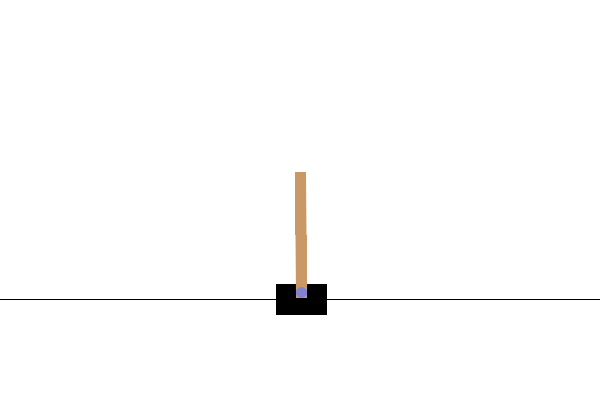

In [46]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

### BEGIN SOLUTION ###

# Initialize the policy neural network
policy_nn = PolicyNetwork(n_observations=state_size, n_actions=action_size)

# Sample an episode using the policy network
episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(
    env, 
    policy_nn, 
    max_episode_duration=200, 
    render=True  # Ensure rendering for GIF generation
)

### END SOLUTION ###

env.close()
env.render_wrapper.make_gif(FIGS_DIR / "lab2_reinforce_untained")

In [47]:
episode_states

[array([ 0.01467218, -0.02380124, -0.0112271 , -0.02508354], dtype=float32),
 array([ 0.01419616,  0.17147991, -0.01172877, -0.32128748], dtype=float32),
 array([ 0.01762575,  0.3667669 , -0.01815452, -0.61764604], dtype=float32),
 array([ 0.02496109,  0.1719032 , -0.03050745, -0.33073577], dtype=float32),
 array([ 0.02839916,  0.36744583, -0.03712216, -0.63288105], dtype=float32),
 array([ 0.03574807,  0.17286089, -0.04977978, -0.3521161 ], dtype=float32),
 array([ 0.03920529,  0.36865407, -0.0568221 , -0.6600713 ], dtype=float32),
 array([ 0.04657837,  0.17436701, -0.07002353, -0.38580775], dtype=float32),
 array([ 0.05006571, -0.01969464, -0.07773969, -0.11599874], dtype=float32),
 array([ 0.04967182, -0.21362162, -0.08005966,  0.15118071], dtype=float32),
 array([ 0.04539939, -0.01744998, -0.07703605, -0.16564663], dtype=float32),
 array([ 0.04505039,  0.17868535, -0.08034898, -0.48160326], dtype=float32),
 array([ 0.04862409,  0.37484404, -0.08998104, -0.7984892 ], dtype=float32),

In [48]:
episode_actions

[1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]

In [49]:
episode_rewards

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

#### Implement a test function

**Task 1.6**: Implement the `avg_return_on_multiple_episodes` function that test the given policy $\pi_\theta$ on `num_episodes` episodes (for fixed horizon $T$) and returns the average reward on the `num_episodes` episodes.

The function `avg_return_on_multiple_episodes` is designed to play multiple episodes of a given environment using a specified policy neural network and calculate the average return. It takes as input the environment to play in, the policy neural network to use, the number of episodes to play, the maximum duration of an episode, and an optional parameter to decide whether to render the environment or not. 
In each episode, it uses the `sample_one_episode` function to play the episode and collect the rewards. The function then returns the average of these cumulated rewards.

`avg_return_on_multiple_episodes` will be used for evaluating the performance of a policy over multiple episodes.

In [52]:
def avg_return_on_multiple_episodes(env: gym.Env,
                                    policy_nn: PolicyNetwork,
                                    num_test_episode: int,
                                    max_episode_duration: int,
                                    render: bool = False) -> float:
    """
    Play multiple episodes of the environment and calculate the average return.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    num_test_episode : int
        The number of episodes to play.
    max_episode_duration : int
        The maximum duration of an episode.
    render : bool, optional
        Whether to render the environment, by default False.

    Returns
    -------
    float
        The average return.
    """

    ### BEGIN SOLUTION ###

    return_list = []

    for _ in range(num_test_episode):
        _, _, episode_rewards, _ = sample_one_episode(env, policy_nn, max_episode_duration, render)
        return_list.append(sum(episode_rewards))

    average_return = sum(return_list) / num_test_episode

    ### END SOLUTION ###

    return average_return

**Task 1.7:** Test this function on the untrained agent.

In [53]:
env = gym.make("CartPole-v1")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

### BEGIN SOLUTION ###

policy_nn = PolicyNetwork(n_observations=state_size, n_actions=action_size)
average_return = avg_return_on_multiple_episodes(env, policy_nn, num_test_episode=3, max_episode_duration=200)

### END SOLUTION ###

print(average_return)

env.close()

16.0


#### Implement the train function

**Task 1.8**: Implement the `train_reinforce_discrete` function, used to train a policy network using the REINFORCE algorithm in the given environment. This function takes as input the environment, the number of training episodes, the number of tests to perform per episode, the maximum duration of an episode, and the learning rate for the optimizer.

The function first initializes a policy network and an Adam optimizer. Then, for each training episode, it generates an episode using the current policy and calculates the return at each time step. It uses this return and the log probability of the action taken at that time step to compute the loss, which is the negative of the product of the return and the log probability. This loss is used to update the policy network parameters using gradient ascent.

After each training episode, the function tests the current policy by playing a number of test episodes and calculating the average return. This average return is added to a list for monitoring purposes.

The function returns the trained policy network and the list of average returns for each episode. This function encapsulates the main loop of the REINFORCE algorithm, including the policy update step. Please refer back to the algorithm outlined at the start of Part 1 for additional context, if necessary.

In [58]:
def train_reinforce_discrete(env: gym.Env,
                             num_train_episodes: int,
                             num_test_per_episode: int,
                             max_episode_duration: int,
                             learning_rate: float) -> Tuple[PolicyNetwork, List[float]]:
    """
    Train a policy using the REINFORCE algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_train_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode, by default EPISODE_DURATION.
    learning_rate : float
        The initial step size.

    Returns
    -------
    Tuple[PolicyNetwork, List[float]]
        The final trained policy and the average returns for each episode.
    """
    episode_avg_return_list = []

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n.item()

    policy_nn = PolicyNetwork(state_size, action_size)
    optimizer = torch.optim.Adam(policy_nn.parameters(), lr=learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):

        ### BEGIN SOLUTION ###

        # Generate an episode following the current policy
        episode_states, episode_actions, episode_reward_list, episode_log_prob_action_list = sample_one_episode(
            env, policy_nn, max_episode_duration, render=False
        )

        # Compute the total return for the episode (REINFORCE)
        G = 0  # Initialize return
        returns = []

        # Calculate returns (discounted future rewards) for each time step
        for reward in reversed(episode_reward_list):
            G = reward + 0.99 * G  # Gamma (discount factor) = 0.99
            returns.insert(0, G)  # Insert at the beginning to reverse the order

        # Normalize returns for better performance (optional)
        returns = torch.tensor(returns, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # Iterate over the episode and apply the policy gradient
        for t in range(len(episode_reward_list)):

            # Convert the log probability at time t to a PyTorch tensor
            log_prob_actions_tensor = episode_log_prob_action_list[t]

            # Calculate the loss: -log_prob * return (for gradient ascent)
            loss = -log_prob_actions_tensor * returns[t]

            # Backpropagation and policy update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        ### END SOLUTION ###

        # Test the current policy
        test_avg_return = avg_return_on_multiple_episodes(env=env,
                                                          policy_nn=policy_nn,
                                                          num_test_episode=num_test_per_episode,
                                                          max_episode_duration=max_episode_duration,
                                                          render=False)

        # Monitoring
        episode_avg_return_list.append(test_avg_return)

    return policy_nn, episode_avg_return_list

#### Train the agent

In [59]:
env = gym.make('CartPole-v1')

NUMBER_OF_TRAININGS = DEFAULT_NUMBER_OF_TRAININGS    # Change the default (global) value here if you want a specific number of trainings for this exercise
reinforce_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Train the agent
    reinforce_policy_nn, episode_reward_list = train_reinforce_discrete(env=env,
                                                                        num_train_episodes=250,
                                                                        num_test_per_episode=5,
                                                                        max_episode_duration=200,
                                                                        learning_rate=0.01)

    reinforce_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_trains_result_list[1].extend(episode_reward_list)
    reinforce_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_trains_result_df = pd.DataFrame(np.array(reinforce_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_trains_result_df["agent"] = "REINFORCE"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, MODELS_DIR / "lab2_reinforce_policy_network.pth")

env.close()

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

#### Plot results

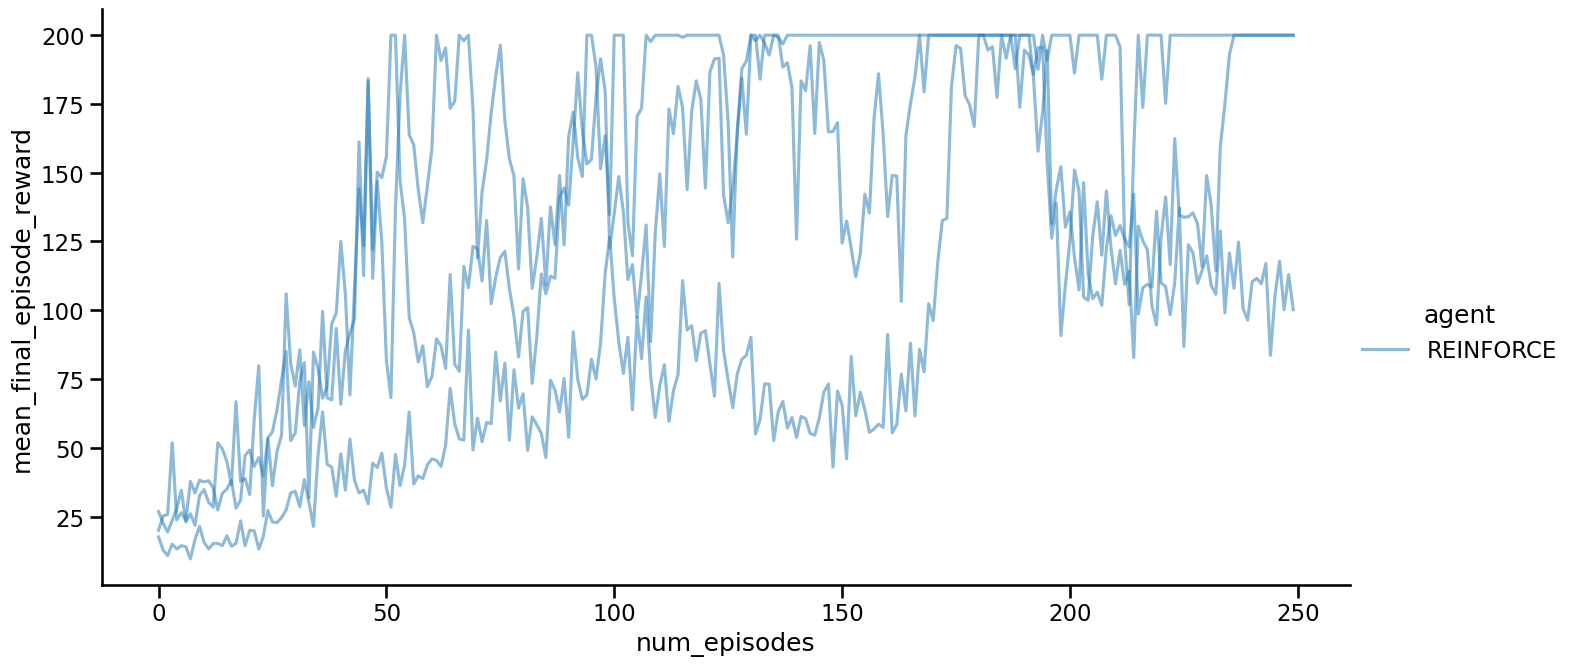

In [60]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=reinforce_trains_result_df, height=7, aspect=2, alpha=0.5)
plt.savefig(PLOTS_DIR / "lab2_reinforce_cartpole_trains_result.png")

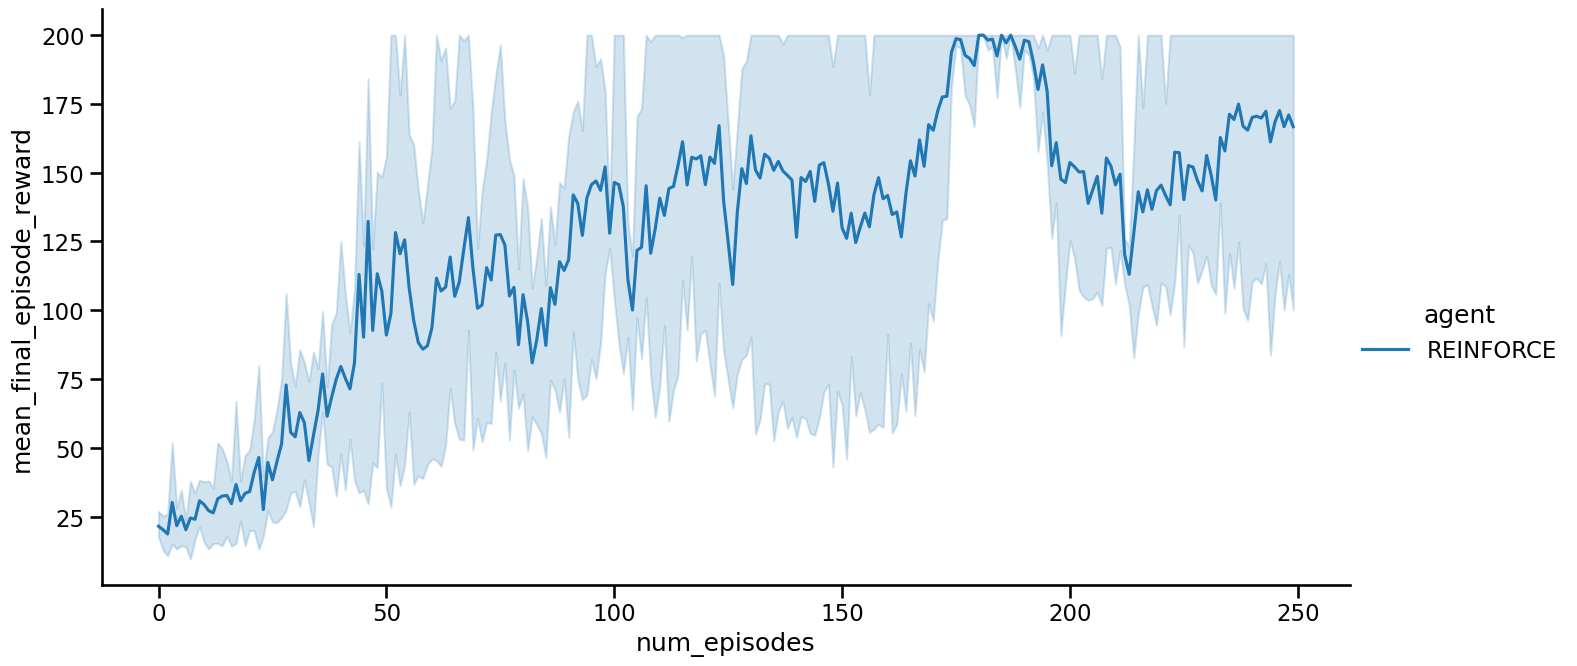

In [61]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_trains_result_df, height=7, aspect=2)
plt.savefig(PLOTS_DIR / "lab2_reinforce_cartpole_trains_result_agg.png")

#### Test final policy

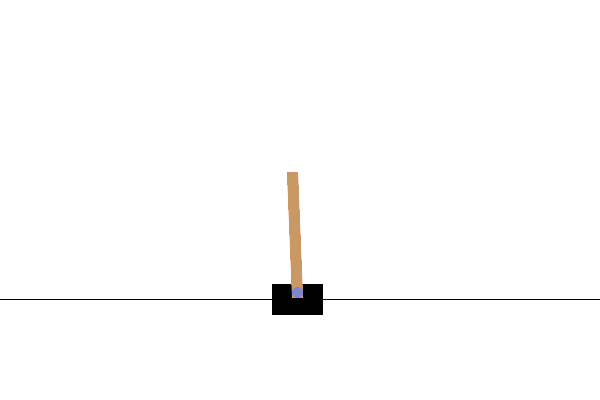

In [62]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, reinforce_policy_nn, 200, render=True)

env.close()
env.render_wrapper.make_gif(FIGS_DIR / "lab2_reinforce_tained")

**Task 1.9**: decrease the learning rate value (e.g. 0.001), increase the number of episodes per training and retrain the agent. What do you observe ?

### Exercise 2: REINFORCE with Baseline

In the basic REINFORCE algorithm, the policy parameters are updated in proportion to the product of the gradient of the policy log-probability and the cumulative reward (return) from a state-action pair. However, this approach can lead to high variance in policy updates, making learning slower and less stable.

The baseline is introduced to reduce this variance. It is a value subtracted from the cumulative reward when calculating the policy gradient. The key property of the baseline is that it does not affect the expected value of the gradient estimate, which means it doesn't bias the learning process but reduces the variance of the updates.

The baseline can be thought of as a reference point or an "average" expectation of reward. By comparing the actual rewards to this baseline, we can determine whether the outcomes of certain actions are better or worse than this "average" performance.

A common choice for the baseline is the value function of the current policy, $\hat{V}_{\boldsymbol{\omega}}$. By using the value function as a baseline, the algorithm adjusts the policy towards actions that perform better than the average.

To incorporate the baseline into REINFORCE, you modify the update rule. Instead of using the total return $G$​ directly, you subtract the baseline value $\hat{V}_{\boldsymbol{\omega}}$ from $G$​ in the policy gradient estimate.

By centering the rewards around a baseline, the variance of the policy gradient estimates is reduced. This leads to more stable and efficient learning, as the updates are less noisy and more focused on improving relative to the average performance.

#### REINFORCE with Baseline

<b>REQUIRE</b> <br>
 $\quad$ A differentiable policy $\pi_{\boldsymbol{\theta}}$ <br>
 $\quad$ A differentiable baseline function $\hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s})$ <br>
 $\quad$ A learning rate $\alpha_1 \in \mathbb{R}^+$ for the policy <br>
 $\quad$ A learning rate $\alpha_2 \in \mathbb{R}^+$ for the baseline <br>
<b>INITIALIZATION</b> <br>
 $\quad$ Initialize parameters $\boldsymbol{\theta} \in \mathbb{R}^d$ <br>
 $\quad$ Initialize parameters $\boldsymbol{\omega} \in \mathbb{R}^d$ <br>
<br>
<b>FOR EACH</b> episode <br>
 $\quad$ Generate full trace $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$ following $\pi_{\boldsymbol{\theta}}$ <br>
 $\quad$ <b>FOR</b> $~ t=0,\dots,T-1$ <br>
  $\quad\quad$ $G \leftarrow \sum_{k=t}^{T-1} r_k$ <br>
  $\quad\quad$ $\delta_t \leftarrow G - \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s}_t)$ <br>
  $\quad\quad$ $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha_1 ~ \delta_t ~ \nabla_{\boldsymbol{\theta}} \ln \pi_{\boldsymbol{\theta}}(\boldsymbol{a}_t|\boldsymbol{s}_t)$ <br>
  $\quad\quad$ $\boldsymbol{\omega} \leftarrow \boldsymbol{\omega} + \alpha_2 ~ \delta_t \nabla_{\boldsymbol{\omega}}\hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s}_t) $ <br>
<br>
<b>RETURN</b> $\boldsymbol{\theta}$

**Task 1.10**: Implement the `ValueNetwork` ($\hat{V}_{\boldsymbol{\omega}}$ in the algorithm) defined as follow.

`ValueNetwork` is a two-layer fully connected neural network. It takes an input tensor representing the state of the environment and outputs a tensor representing the estimated value of that state. The input tensor's shape should be (N, dim), where N is the number of state vectors in the batch and dim is the dimension of the state vectors.

The network has the following components:
- `layer1`: This is a linear (fully connected) layer that takes `n_observations` as input and outputs `nn_l1` neurons.
- `layer2`: This is another linear layer that takes `nn_l1` neurons as input and outputs a single value.
- `forward` method: This method defines the forward pass of the network. It takes a state tensor as input and returns a tensor representing the estimated value of the state. It first applies the ReLU activation function to the output of the first layer, and then applies the second linear layer to get the final output.

This network is quite simple and may not perform well on complex tasks with large state spaces. However, it can be a good starting point for simple reinforcement learning tasks, and can be easily extended with more layers or different types of layers (such as convolutional layers for image inputs) to handle more complex tasks.

In [63]:
class ValueNetwork(torch.nn.Module):
    """
    A two-layer fully connected network that estimates the value of a state.

    Parameters
    ----------
    n_observations : int
        The number of observations in the state.
    nn_l1 : int, optional
        The number of neurons in the first layer, by default 16

    Attributes
    ----------
    layer1 : torch.nn.Linear
        The first fully connected layer.
    layer2 : torch.nn.Linear
        The second fully connected layer.
    """

    def __init__(self, n_observations: int, nn_l1: int = 16):
        super(ValueNetwork, self).__init__()

        ### BEGIN SOLUTION ###

        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, 1)

        ### END SOLUTION ###


    def forward(self, state_tensor: torch.Tensor) -> torch.Tensor:
        """
        Perform a forward pass through the network.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor representing the state.

        Returns
        -------
        torch.Tensor
            The output tensor representing the value of the state.

        """

        ### BEGIN SOLUTION ###

        x = torch.relu(self.layer1(state_tensor))
        x = self.layer2(x)

        ### END SOLUTION ###

        return x

#### Implement the train function

**Task 1.11**: Implement the `train_reinforce_baseline_discrete` function, used to train a policy network and a value network using the REINFORCE with baseline algorithm in a given environment.

The function first initializes a policy network and a value network, along with their respective Adam optimizers. Then, for each training episode, it generates an episode using the current policy and calculates the return at each time step. It uses this return, the log probability of the action taken at that time step, and the estimated value of the state to compute the policy and value losses. These losses are used to update the policy and value network parameters using gradient ascent. The value loss is typically defined as the squared difference between the estimated return and the actual return.

In [64]:
def train_reinforce_baseline_discrete(env: gym.Env,
                                      num_train_episodes: int,
                                      num_test_per_episode: int,
                                      max_episode_duration: int,
                                      policy_learning_rate: float,
                                      value_learning_rate: float) -> Tuple[PolicyNetwork, List[float]]:
    """
    Train a policy using the REINFORCE with baseline algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_train_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode.
    policy_learning_rate : float
        The policy learning rate.
    value_learning_rate : float
        The value learning rate.

    Returns
    -------
    Tuple[PolicyNetwork, List[float]]
        The final trained policy and the average returns for each episode.
    """
    episode_avg_return_list = []

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n.item()

    policy_nn = PolicyNetwork(state_size, action_size)
    policy_optimizer = torch.optim.Adam(policy_nn.parameters(), lr=policy_learning_rate)

    value_nn = ValueNetwork(state_size)
    value_optimizer = torch.optim.Adam(value_nn.parameters(), lr=value_learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):

        # Generate an episode following the current policy
        episode_state_list, _, episode_reward_list, episode_log_prob_action_list = sample_one_episode(env=env,
                                                                                                      policy_nn=policy_nn,
                                                                                                      max_episode_duration=max_episode_duration)

        ### BEGIN SOLUTION ###

        G = 0
        returns = []
        
        for reward in reversed(episode_reward_list):
            G = reward + 0.99 * G
            returns.insert(0, G)
        
        
        returns = torch.tensor(returns, dtype=torch.float32)

        # Iterate over the episode and apply the policy gradient with baseline
        for t in range(len(episode_reward_list)):

            # Get the current state and convert to tensor
            state_t = torch.tensor(episode_state_list[t], dtype=torch.float32).unsqueeze(0)

            # Compute the value (baseline) of the state using the value network
            value_estimate = value_nn(state_t)

            # Calculate the advantage (A_t = G_t - V(s_t))
            advantage = returns[t] - value_estimate

            # Policy loss: -log_prob * advantage
            log_prob_actions_tensor = episode_log_prob_action_list[t]
            policy_loss = -log_prob_actions_tensor * advantage.detach()  # detach advantage to avoid backprop through value net

            # Update policy network
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # Value loss: Mean Squared Error between G_t and V(s_t)
            value_loss = torch.nn.functional.mse_loss(value_estimate, returns[t])

            # Update value network
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()
            

        ### END SOLUTION ###

        # Test the current policy
        test_avg_return = avg_return_on_multiple_episodes(env=env,
                                                          policy_nn=policy_nn,
                                                          num_test_episode=num_test_per_episode,
                                                          max_episode_duration=max_episode_duration,
                                                          render=False)

        # Monitoring
        episode_avg_return_list.append(test_avg_return)

    return policy_nn, episode_avg_return_list

#### Train the agent

In [65]:
env = gym.make('CartPole-v1')

NUMBER_OF_TRAININGS = DEFAULT_NUMBER_OF_TRAININGS    # Change the default (global) value here if you want a specific number of trainings for this exercise
reinforce_baseline_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Train the agent
    reinforce_baseline_policy_nn, episode_reward_list = train_reinforce_baseline_discrete(env=env,
                                                                                          num_train_episodes=250,
                                                                                          num_test_per_episode=5,
                                                                                          max_episode_duration=200,
                                                                                          policy_learning_rate=0.02,
                                                                                          value_learning_rate=0.02)

    reinforce_baseline_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_baseline_trains_result_list[1].extend(episode_reward_list)
    reinforce_baseline_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_baseline_trains_result_df = pd.DataFrame(np.array(reinforce_baseline_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_baseline_trains_result_df["agent"] = "REINFORCE baseline"

# Save the action-value estimation function of the last train

torch.save(reinforce_baseline_policy_nn, MODELS_DIR / "lab2_reinforce_baseline_policy_network.pth")

env.close()

  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_1200733/457701.py:82: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = torch.nn.functional.mse_loss(value_estimate, returns[t])


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

#### Plot results

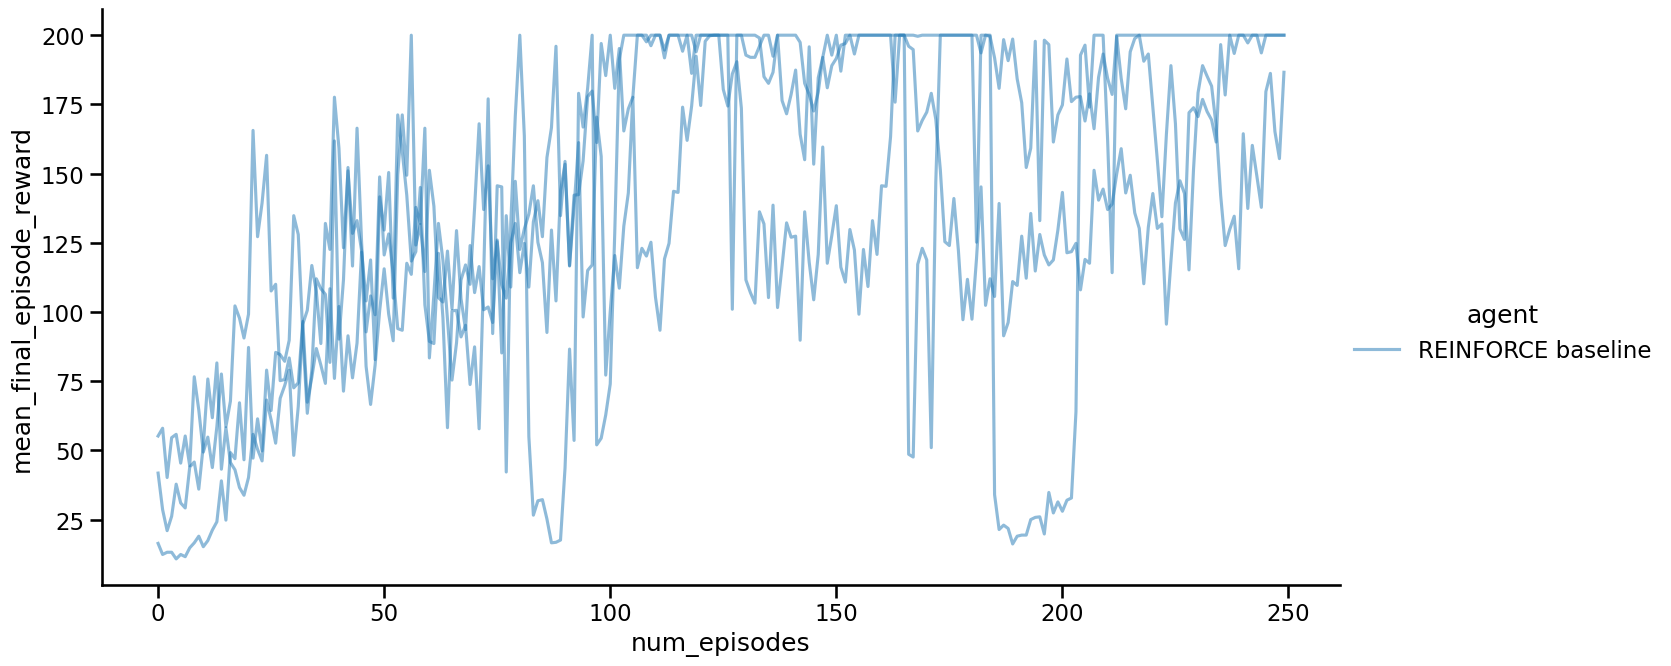

In [66]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=reinforce_baseline_trains_result_df, height=7, aspect=2, alpha=0.5)
plt.savefig(PLOTS_DIR / "lab2_reinforce_cartpole_trains_result.png")

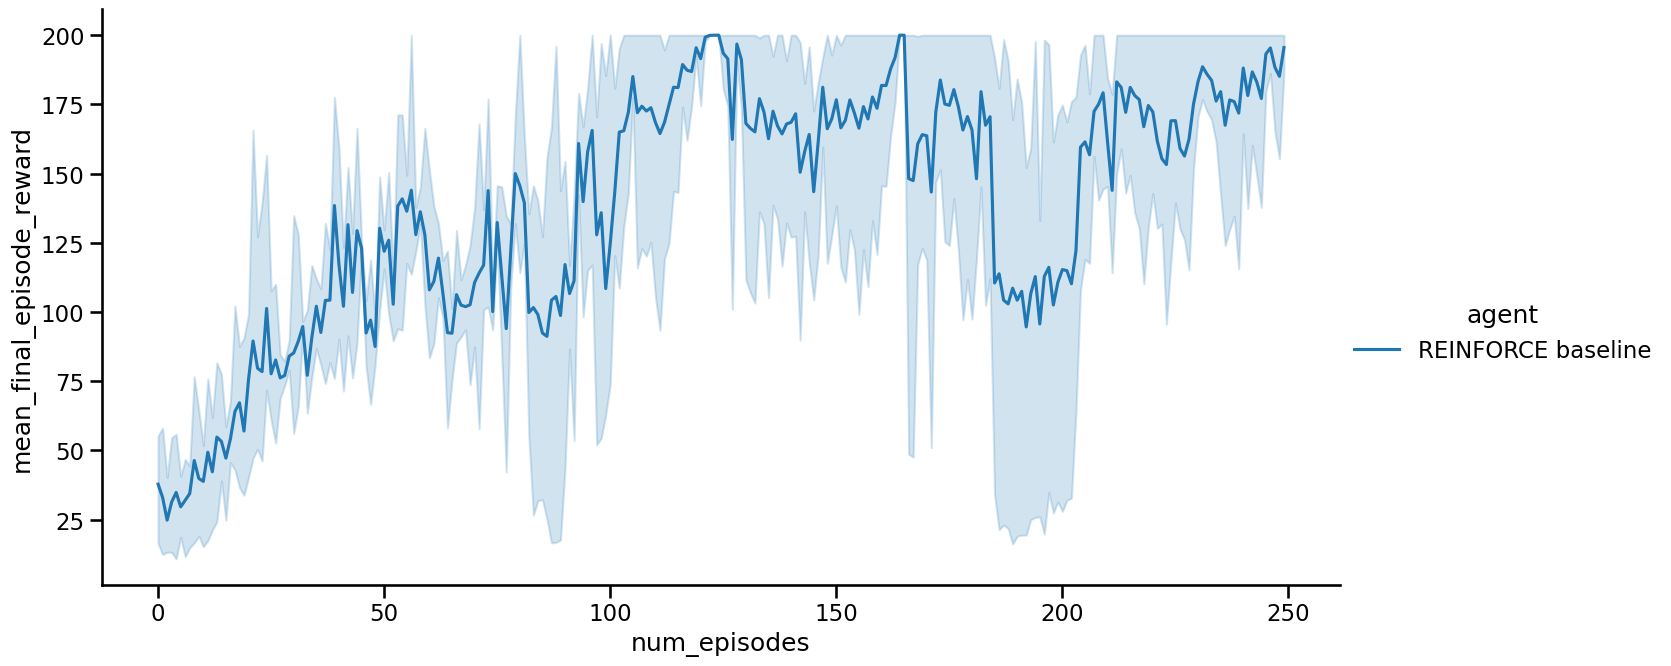

In [67]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_baseline_trains_result_df, height=7, aspect=2)
plt.savefig(PLOTS_DIR / "lab2_reinforce_cartpole_trains_result_agg.png")

#### Test final policy

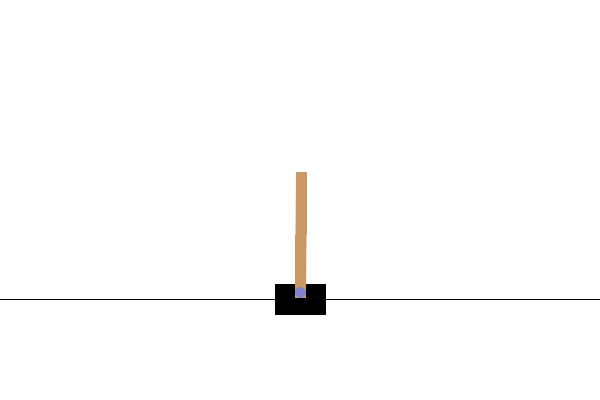

In [68]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, reinforce_policy_nn, 200, render=True)

env.close()
env.render_wrapper.make_gif(FIGS_DIR / "lab2_reinforce_tained")

### Bonus section 1: Implementing REINFORCE for Continuous Action Spaces (Lunar Lander)

The REINFORCE agent we've implemented so far is designed for environments with discrete action spaces. However, policy-based methods can effectively handle large, even continuous, action spaces. Instead of calculating learned probabilities for each possible action, we learn the statistics of the probability distribution. For instance, if the action set comprises real numbers, actions could be chosen from a normal (Gaussian) distribution.

To create a policy parameterization, we can define the policy as the normal probability density over a real-valued scalar action. The mean and standard deviation of this distribution are determined by parametric function approximators (the `PolicyNetwork` neural network) that depend on the state.

We can divide the policy’s parameter vector, $\boldsymbol{\theta} = [ \boldsymbol{\theta}_\mu, \boldsymbol{\theta}_\sigma ]^\top$, into two parts: one for approximating the mean and the other for approximating the standard deviation.

**Task 1.12**: Modify the `PolicyNetwork`, `sample_discrete_action`, and `train_reinforce_discrete` functions to make REINFORCE compatible with the *LunarLander-v2* environment. Remember to set `continuous=True` in the `gym.make` function.

## Part 2: Actor Critic

### Actor Critic with bootstrapping

<b>REQUIRE</b> <br>
 $\quad$ A policy $\pi_{\boldsymbol{\theta}}$ and a value function $V_{\boldsymbol{\omega}}$ <br>
 $\quad$ A learning rate $\alpha_1$ for the critic and $\alpha_2$ for the actor <br>
<b>INITIALIZATION</b> <br>
 $\quad$ $\boldsymbol{\theta} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_n)$ <br>
 $\quad$ $\boldsymbol{\omega} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_n)$ <br>
<br>
<b>FOR EACH</b> episode <br>
 $\quad$ $\boldsymbol{s} \leftarrow \text{env.reset}()$ <br>
 $\quad$ <b>DO</b> <br>
  $\quad\quad$ $\boldsymbol{a} \sim \pi_{\boldsymbol{\theta}}(\cdot | \boldsymbol{s})$ <br>
  $\quad\quad$ $r, \boldsymbol{s'} \leftarrow \text{env.step}(\boldsymbol{a})$ <br>
  $\quad\quad$ $\boldsymbol{\omega} \leftarrow \boldsymbol{\omega} + \alpha_1 \left[ r + \gamma \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s'}) - \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s}) \right] \nabla_{\boldsymbol{\omega}} \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s})$ <br>
  $\quad\quad$ $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha_2 \left[ \nabla_{\boldsymbol{\theta}} ~ \ln \pi_{\boldsymbol{\theta}}(\boldsymbol{a}|\boldsymbol{s}) \times \hat{V}_{\boldsymbol{\omega}}(\boldsymbol{s}) \right]$ <br>
  $\quad\quad$ $\boldsymbol{s} \leftarrow \boldsymbol{s'}$ <br>
 $\quad$ <b>UNTIL</b> $\boldsymbol{s}$ is final <br>
<br>
<b>RETURN</b> $\boldsymbol{\theta}$ <br>

### Bonus section 2: Implementing the simple Actor Critic algorithm to solve the Cartpole problem

**Task**: Implement the Actor Critic algorithm presented above to solve the Cartpole problem

In [70]:
### BEGIN SOLUTION ###
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Hyperparameters
gamma = 0.99  # Discount factor
alpha_critic = 0.01  # Critic learning rate
alpha_actor = 0.001  # Actor learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Actor Network
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        logits = self.fc2(x)
        action_probs = torch.softmax(logits, dim=-1)
        return action_probs

# Critic Network
class ValueNetwork(nn.Module):
    def __init__(self, state_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        state_value = self.fc2(x)
        return state_value

# Function to select action based on policy network
def select_action(policy_net, state):
    state = torch.from_numpy(state).float().to(device)
    action_probs = policy_net(state)
    action_dist = torch.distributions.Categorical(action_probs)
    action = action_dist.sample()
    return action.item(), action_dist.log_prob(action)

# Function to train the actor-critic
def train_actor_critic(env, num_episodes, gamma, alpha_actor, alpha_critic):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Initialize Actor and Critic
    policy_net = PolicyNetwork(state_size, action_size).to(device)
    value_net = ValueNetwork(state_size).to(device)

    # Optimizers for Actor and Critic
    policy_optimizer = optim.Adam(policy_net.parameters(), lr=alpha_actor)
    value_optimizer = optim.Adam(value_net.parameters(), lr=alpha_critic)

    for episode in range(num_episodes):
        state, _ = env.reset()  # Extract state from the reset tuple
        done = False

        while not done:
            # Select action using policy network (Actor)
            action, log_prob = select_action(policy_net, state)
            
            # Step environment
            next_state, reward, done, _ = env.step(action)

            # Convert state and next_state to tensors
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
            next_state_tensor = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
            reward_tensor = torch.tensor(reward, dtype=torch.float32).to(device)

            # Calculate value for current state and next state (Critic)
            value = value_net(state_tensor)
            next_value = value_net(next_state_tensor)

            # Compute TD error for Critic
            td_error = reward_tensor + gamma * next_value * (1 - int(done)) - value

            # Update Critic (Value Network)
            value_loss = td_error.pow(2).mean()
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            # Compute policy loss for Actor
            policy_loss = -log_prob * td_error.detach()

            # Update Actor (Policy Network)
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # Move to next state
            state = next_state

        if episode % 10 == 0:
            print(f'Episode {episode}/{num_episodes}')

    return policy_net

# Main function to train the actor-critic algorithm

if __name__ == "__main__":
    env = gym.make('CartPole-v1')

    # Train the Actor-Critic model
    num_episodes = 500
    # Extract the state correctly if env.reset() returns a tuple
    trained_policy = train_actor_critic(env, num_episodes, gamma, alpha_actor, alpha_critic)

    # Test the trained policy
    state, _ = env.reset()  # Handle the tuple returned by reset()
    done = False
    total_reward = 0

    while not done:
        env.render()
        action, _ = select_action(trained_policy, state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state

    print(f'Total reward after training: {total_reward}')
    env.close()




### END SOLUTION ###

/users/eleves-a/2023/heyuan.liu/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


ValueError: too many values to unpack (expected 4)

## Bonus section 3: Monitoring the training process with Weights & Biases on top of Tensorboard

In the previous lab, we have seen how to monitor the training process using Tensorboard and Weights & Biases separately. In this bonus section, we will see how to use Weights & Biases on top of Tensorboard to monitor the training process. Then, with only one line of code, you can switch between the two tools without changing your code.

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import warnings
from dataclasses import dataclass

@dataclass
class Hyperparameters:
    lr: float
    batch_size: int

hparams = Hyperparameters(lr=0.01, batch_size=32)

try:
    import wandb

    # wandb.login()
    wandb.init(
        project="INF639",
        sync_tensorboard=True,
        monitor_gym=True,
        config=vars(hparams)
    )
except:
    warnings.warn("Wandb is not installed")


# Simple example: model and data
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(10, 1)

    def forward(self, x):
        return self.fc(x)

# Creating a model, optimizer, and loss function
model = SimpleModel()
optimizer = optim.SGD(model.parameters(), lr=hparams.lr)
loss_fn = nn.MSELoss()

# Initializing TensorBoard SummaryWriter
writer = SummaryWriter()

# Training example
for epoch in range(10):
    # Fake data
    inputs = torch.randn(hparams.batch_size, 10)
    targets = torch.randn(hparams.batch_size, 1)

    # Forward pass
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the loss values to TensorBoard
    writer.add_scalar('Loss/train', loss.item(), epoch)

# Closing SummaryWriter
writer.close()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: liuheyuan (liuheyuan-ecole-polytechnique). Use `wandb login --relogin` to force relogin


In [72]:
# Load TensorBoard extension in Colab
%load_ext tensorboard
%tensorboard --logdir ./runs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## Bonus section 4: Stable Baselines 3 and MuJoCo


It is important to be able to write reinforcement learning (RL) algorithms from scratch, as it helps in deeply understanding the underlying concepts, mechanisms, and trade-offs involved in RL. This skill is essential for debugging, optimizing, and innovating beyond standard approaches. However, in many practical cases, leveraging well-established libraries like Stable Baselines 3 (SB3) can be incredibly useful for solving real-world RL problems. SB3 provides tested, efficient, and optimized implementations of various algorithms, saving time and ensuring reliability when applying RL to concrete tasks. Knowing how to balance custom implementations with using proven tools like SB3 is key to efficiently developing and deploying RL solutions.

In this bonus section, we will first use SB3 to solve the Cartpole environment. We will then move on to the MuJoCo environment, which is more complex and requires a more advanced algorithm to solve.

There is no exercise in this section. You can run the code and observe the results.

### Train a PPO agent on Cartpole with Stable Baselines 3

We start with a very concise example. The code below trains a PPO agent on the Cartpole environment using Stable Baselines 3. The code is very simple and requires only a few lines to set up the environment, create the agent, and train it.

In [73]:
# env = make_vec_env("CartPole-v1", n_envs=4)   # Parallel environments
env = gym.make("CartPole-v1", render_mode='rgb_array')

model = PPO(
    "MlpPolicy",
    env,
    verbose=1
)

model.learn(total_timesteps=100_000)
model.save(MODELS_DIR / "lab2_ppo_cartpole")

env.close()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/users/eleves-a/2023/heyuan.liu/.local/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/users/eleves-a/2023/heyuan.liu/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | 23       |
| time/              |          |
|    fps             | 1074     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.7        |
|    ep_rew_mean          | 27.7        |
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008284992 |
|    clip_fraction        | 0.0848      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.00795     |
|    learning_rate        | 0.

We then evaluate the agent by running it in the environment and generate a video of the agent's performance.

In [ ]:
VIDEO_DIRNAME = "lab2_cartpole_sb3_ppo_basic"

env = gym.make("CartPole-v1", render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

model = PPO.load(MODELS_DIR / "lab2_ppo_cartpole")

observation, info = env.reset()
for _ in range(200):
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

### Train a PPO agent on Cartpole with Stable Baselines 3 and evaluation callback

We will now add an evaluation callback to the training process. This callback will evaluate the agent at regular intervals during training and save the evaluation results. This allows us to monitor the agent's performance during training and analyze how it improves over time.

In [ ]:
# env = make_vec_env("CartPole-v1", n_envs=4)   # Parallel environments
env = gym.make("CartPole-v1", render_mode='rgb_array')

model = PPO(
    "MlpPolicy",
    env,
    verbose=1
)

# Define a callback to periodically evaluate the model
eval_env = gym.make("CartPole-v1")
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=MODELS_DIR / "lab2_ppo_cartpole_best",
    log_path=LOGS_DIR / "lab2_ppo_cartpole",
    eval_freq=5000,
    deterministic=True,
    render=False
)

# Train the agent
model.learn(
    total_timesteps=50_000,
    callback=eval_callback
)

# Save the trained model
model.save(MODELS_DIR / "lab2_ppo_cartpole")

In [32]:
# Load the evaluation results (results_array will contain the following keys: timesteps, results, ep_lengths)
results_array = np.load(LOGS_DIR / "lab2_ppo_cartpole" / "evaluations.npz")

In [ ]:

# Plot the evaluation results
plt.plot(results_array['timesteps'], results_array['results'])
plt.xlabel("Timesteps")
plt.ylabel("Mean reward")
plt.title("Evaluation results")
plt.savefig(PLOTS_DIR / "lab2_ppo_cartpole_eval.png")
plt.show()

In [ ]:

# Plot the evaluation results
plt.plot(results_array['timesteps'], results_array['ep_lengths'])
plt.xlabel("Timesteps")
plt.ylabel("Episode Length")
plt.title("Episode Length vs Timesteps")
plt.savefig(PLOTS_DIR / "lab2_ppo_cartpole_ep_lenghts.png")
plt.show()

### Train a PPO agent on Cartpole with Stable Baselines 3 monitoring the training process with Tensorboard

We will now monitor the training process using Tensorboard. This allows us to visualize various metrics such as the reward, the loss, and the entropy of the policy during training. This can help us understand how the agent learns and how the training process evolves over time.

In [ ]:
# env = make_vec_env("CartPole-v1", n_envs=4)   # Parallel environments
env = gym.make("CartPole-v1", render_mode='rgb_array')

# Initialize the PPO model
model = PPO(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log=LOGS_DIR / "lab2_ppo_cartpole_tb"
)

# Train the agent
model.learn(
    total_timesteps=50_000,
    progress_bar=True
)

# Save the trained model
model.save(MODELS_DIR / "lab2_ppo_cartpole")

### Train a PPO agent on Cartpole with Stable Baselines 3 monitoring the training process with Weights & Biases

We will now monitor the training process using Weights & Biases. Videos of the agent's performance will be saved and can be viewed in the Weights & Biases dashboard. This allows us to visualize the agent's behavior during training and analyze how it improves over time.

In [ ]:
@dataclass
class Hyperparameters:
    total_timesteps: int

hparams = Hyperparameters(
    total_timesteps=1_000_000
)

# If wandb is installed, initialize it
if "wandb" in sys.modules:
    wandb.init(
        project="INF639",
        sync_tensorboard=True,
        monitor_gym=True,
        config=vars(hparams)
    )

VIDEO_DIRNAME = "lab2_ppo_cartpole"

# env = make_vec_env("CartPole-v1", n_envs=4)   # Parallel environments
env = gym.make("CartPole-v1", render_mode='rgb_array')
env = gym.wrappers.RecordVideo(
    env,
    FIGS_DIR / VIDEO_DIRNAME,
    disable_logger=True
)

model = PPO(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log=LOGS_DIR / "lab2_ppo_cartpole_tb"
)

model.learn(
    total_timesteps=hparams.total_timesteps
)
model.save(MODELS_DIR / "lab2_ppo_cartpole")

env.close()

#### Choose different policies

So far, we have used the default policy for the PPO agent. However, Stable Baselines 3 provides several other policies that can be used with the PPO agent. In this section, we will experiment with different policies and observe how they affect the agent's performance.

In [ ]:
@dataclass
class Hyperparameters:
    total_timesteps: int
    actor_num_hidden_layer: int
    critic_num_hidden_layer: int
    actor_hidden_layer_units: int
    critic_hidden_layer_units: int

hparams = Hyperparameters(
    total_timesteps=50_000,
    actor_num_hidden_layer=2,
    critic_num_hidden_layer=2,
    actor_hidden_layer_units=32,
    critic_hidden_layer_units=32
)

# If wandb is installed, initialize it
if "wandb" in sys.modules:
    wandb.init(
        project="INF639",
        sync_tensorboard=True,
        monitor_gym=True,
        config=vars(hparams)
    )

VIDEO_DIRNAME = "lab2_ppo_cartpole_custom_policy"

# env = make_vec_env("CartPole-v1", n_envs=4)   # Parallel environments
env = gym.make("CartPole-v1", render_mode='rgb_array')
env = gym.wrappers.RecordVideo(
    env,
    FIGS_DIR / VIDEO_DIRNAME,
    disable_logger=True
)

net_arch_dict = {
    "pi": [hparams.actor_hidden_layer_units for _ in range(hparams.actor_num_hidden_layer)],
    "vf": [hparams.critic_hidden_layer_units for _ in range(hparams.critic_num_hidden_layer)],
}

# Define a custom architecture for the networks
policy_kwargs = dict(
    # net_arch=[dict(pi=[128, 128], vf=[128, 128])],  # Network architecture with 2 layers of 128 units for the actor and the critic
    #net_arch=[dict(pi=[hparams.actor_hidden_layer_units], vf=[hparams.critic_hidden_layer_units])],                # Network architecture with 1 layer of 16 units for the actor and the critic
    net_arch=net_arch_dict,                # Network architecture with 1 layer of 16 units for the actor and the critic
    activation_fn=torch.nn.Tanh                       # Activation function for each layer (here Tanh)
)

# Initialize the PPO model with a custom architecture
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,     # Use the custom policy
    verbose=0,
    tensorboard_log=LOGS_DIR / "lab2_ppo_cartpole_tb"
)

# Train the model
model.learn(
    total_timesteps=hparams.total_timesteps,
    progress_bar=True
)

# Save the model
model.save(MODELS_DIR / "lab2_ppo_cartpole_custom")

env.close()

### Hands on MuJoCo environment

We now switch to the MuJoCo environment, which is more complex and requires a more advanced algorithm to solve.

MuJoCo environments are widely used benchmarks for testing reinforcement learning algorithms. They consist of 11 robotics tasks, all of which involve continuous control with continuous action spaces.

You can find a detailed description of the MuJoCo environments [here](https://gymnasium.farama.org/environments/mujoco/).

In this lab, we will work with the `Ant-v4` environment. In this task, the agent controls a four-legged robot, guiding it to move forward as quickly as possible. The agent earns a reward based on the distance the robot covers.

This environment is described [here](https://gymnasium.farama.org/environments/mujoco/ant/).

Print some information about the environment:

In [ ]:
env = gym.make('Ant-v4', render_mode="rgb_array")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space

print(f"State space : { env.observation_space }")
print(f"Action space : { env.action_space }")

env.close()

Run the following cells and check different basic 
policies (for instance randomly drawn actions) to discover the environment.

In [ ]:
VIDEO_DIRNAME = "lab2_mujoco_zero_policy"

env = gym.make('Ant-v4', render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

observation, info = env.reset()
done = False

for _ in range(100):
    if not done:
        print(".", end="")
    else:
        print("x", end="")

    action = np.zeros(env.action_space.shape)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

In [ ]:
VIDEO_DIRNAME = "lab2_mujoco_one_policy"

env = gym.make('Ant-v4', render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

observation, info = env.reset()
done = False

for _ in range(100):
    if not done:
        print(".", end="")
    else:
        print("x", end="")

    action = np.ones(env.action_space.shape)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

In [ ]:
VIDEO_DIRNAME = "lab2_mujoco_minus_one_policy"

env = gym.make('Ant-v4', render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

observation, info = env.reset()
done = False

for _ in range(100):
    if not done:
        print(".", end="")
    else:
        print("x", end="")

    action = np.full(env.action_space.shape, -1.)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

In [ ]:
VIDEO_DIRNAME = "lab2_mujoco_random_uniform_policy"

env = gym.make('Ant-v4', render_mode='rgb_array', terminate_when_unhealthy=False)
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

observation, info = env.reset()
done = False

for _ in range(100):
    if not done:
        print(".", end="")
    else:
        print("x", end="")

    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

In [ ]:
VIDEO_DIRNAME = "lab2_mujoco_random_normal_policy"

env = gym.make('Ant-v4', render_mode='rgb_array', terminate_when_unhealthy=False)
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

observation, info = env.reset()
done = False

for _ in range(100):
    if not done:
        print(".", end="")
    else:
        print("x", end="")

    action = np.random.normal(size=env.action_space.shape)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

**Task**: Read the [MuJoCo Ant environment documentation](https://gymnasium.farama.org/environments/mujoco/ant/) to understand the state and action spaces, as well as the reward structure and the termination conditions.

### Train a PPO agent on MuJoCo with Stable Baselines 3

In [ ]:
@dataclass
class Hyperparameters:
    total_timesteps: int

hparams = Hyperparameters(
    total_timesteps=1_000_000
)

# If wandb is installed, initialize it
if "wandb" in sys.modules:
    wandb.init(
        project="INF639_lab2_mujoco_ant",
        name="ppo",
        sync_tensorboard=True,
        monitor_gym=True,
        config=vars(hparams)
    )

VIDEO_DIRNAME = "lab2_mujoco_sb3_ppo_policy"

# Create the Ant-v4 environment from Gymnasium
env_id = 'Ant-v4'
# env = make_vec_env(env_id, n_envs=4)  # Use multiple environments for parallelism
env = gym.make(env_id, render_mode='rgb_array')
env = gym.wrappers.RecordVideo(         # Record the video of the environment (visible on Weight & Biases)
    env,
    FIGS_DIR / VIDEO_DIRNAME,
    disable_logger=True
)

# Initialize the PPO model
model = PPO(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log=LOGS_DIR / "lab2_ppo_mujoco_tb"
)

# # Define a callback to periodically evaluate the model
# eval_env = gym.make(env_id)
# eval_callback = EvalCallback(
#     eval_env,
#     best_model_save_path=MODELS_DIR / "lab2_ppo_mujoco_best",
#     log_path=LOGS_DIR / "lab2_ppo_mujoco",
#     eval_freq=5000,
#     deterministic=True,
#     render=False
# )

# Train the agent
model.learn(
    # progress_bar=True,
    # callback=eval_callback,
    total_timesteps=hparams.total_timesteps
)

# Save the trained model
model.save(MODELS_DIR / "lab2_ppo_mujoco")

env.close()

In [ ]:
env = gym.make("Ant-v4", render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

model = PPO.load(MODELS_DIR / "lab2_ppo_mujoco")
# model = PPO.load(MODELS_DIR / "lab2_ppo_mujoco_best")

observation, info = env.reset()
for _ in range(500):
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

### Train a A2C agent on MuJoCo with Stable Baselines 3

In [ ]:
from stable_baselines3 import A2C

@dataclass
class Hyperparameters:
    total_timesteps: int

hparams = Hyperparameters(
    total_timesteps=1_000_000
)

# If wandb is installed, initialize it
if "wandb" in sys.modules:
    wandb.init(
        project="INF639_lab2_mujoco_ant",
        name="a2c",
        sync_tensorboard=True,
        monitor_gym=True,
        config=vars(hparams)
    )

VIDEO_DIRNAME = "lab2_mujoco_sb3_a2c_policy"

# Create the Ant-v4 environment from Gymnasium
env_id = 'Ant-v4'
env = gym.make(env_id, render_mode='rgb_array')
env = gym.wrappers.RecordVideo(         # Record the video of the environment (visible on Weight & Biases)
    env,
    FIGS_DIR / VIDEO_DIRNAME,
    disable_logger=True
)

# Initialize the A2C model
model = A2C(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log=LOGS_DIR / "lab2_a2c_mujoco_tb"
)

# Train the agent
model.learn(
    total_timesteps=hparams.total_timesteps
)

# Save the trained model
model.save(MODELS_DIR / "lab2_a2c_mujoco")

env.close()

In [ ]:
env = gym.make("Ant-v4", render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

model = A2C.load(MODELS_DIR / "lab2_a2c_mujoco")

observation, info = env.reset()
for _ in range(500):
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

### Train a DDPG agent on MuJoCo with Stable Baselines 3

In [ ]:
from stable_baselines3 import DDPG

@dataclass
class Hyperparameters:
    total_timesteps: int

hparams = Hyperparameters(
    total_timesteps=1_000_000
)

# If wandb is installed, initialize it
if "wandb" in sys.modules:
    wandb.init(
        project="INF639_lab2_mujoco_ant",
        name="ddpg",
        sync_tensorboard=True,
        monitor_gym=True,
        config=vars(hparams)
    )

VIDEO_DIRNAME = "lab2_mujoco_sb3_ddpg_policy"

# Create the Ant-v4 environment from Gymnasium
env_id = 'Ant-v4'
# env = make_vec_env(env_id, n_envs=4)  # Use multiple environments for parallelism
env = gym.make(env_id, render_mode='rgb_array')
env = gym.wrappers.RecordVideo(         # Record the video of the environment (visible on Weight & Biases)
    env,
    FIGS_DIR / VIDEO_DIRNAME,
    disable_logger=True
)

# Initialize the DDPG model
model = DDPG(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log=LOGS_DIR / "lab2_ddpg_mujoco_tb"
)

# Train the agent
model.learn(
    total_timesteps=hparams.total_timesteps
)

# Save the trained model
model.save(MODELS_DIR / "lab2_ddpg_mujoco")

env.close()

In [ ]:
env = gym.make("Ant-v4", render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

model = DDPG.load(MODELS_DIR / "lab2_ddpg_mujoco")

observation, info = env.reset()
for _ in range(500):
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

### Train a TD3 agent on MuJoCo with Stable Baselines 3

In [ ]:
from stable_baselines3 import TD3

@dataclass
class Hyperparameters:
    total_timesteps: int

hparams = Hyperparameters(
    total_timesteps=1_000_000
)

# If wandb is installed, initialize it
if "wandb" in sys.modules:
    wandb.init(
        project="INF639_lab2_mujoco_ant",
        name="td3",
        sync_tensorboard=True,
        monitor_gym=True,
        config=vars(hparams)
    )

VIDEO_DIRNAME = "lab2_mujoco_sb3_td3_policy"

# Create the Ant-v4 environment from Gymnasium
env_id = 'Ant-v4'
# env = make_vec_env(env_id, n_envs=4)  # Use multiple environments for parallelism
env = gym.make(env_id, render_mode='rgb_array')
env = gym.wrappers.RecordVideo(         # Record the video of the environment (visible on Weight & Biases)
    env,
    FIGS_DIR / VIDEO_DIRNAME,
    disable_logger=True
)

# Initialize the TD3 model
model = TD3(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log=LOGS_DIR / "lab2_td3_mujoco_tb"
)

# Train the agent
model.learn(
    total_timesteps=hparams.total_timesteps
)

# Save the trained model
model.save(MODELS_DIR / "lab2_td3_mujoco")

env.close()

In [ ]:
env = gym.make("Ant-v4", render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

model = TD3.load(MODELS_DIR / "lab2_td3_mujoco")

observation, info = env.reset()
for _ in range(500):
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")

### Train a SAC agent on MuJoCo with Stable Baselines 3

In [ ]:
from stable_baselines3 import SAC

@dataclass
class Hyperparameters:
    total_timesteps: int

hparams = Hyperparameters(
    total_timesteps=1_000_000
)

# If wandb is installed, initialize it
if "wandb" in sys.modules:
    wandb.init(
        project="INF639_lab2_mujoco_ant",
        name="sac",
        sync_tensorboard=True,
        monitor_gym=True,
        config=vars(hparams)
    )

VIDEO_DIRNAME = "lab2_mujoco_sb3_sac_policy"

# Create the Ant-v4 environment from Gymnasium
env_id = 'Ant-v4'
# env = make_vec_env(env_id, n_envs=4)  # Use multiple environments for parallelism
env = gym.make(env_id, render_mode='rgb_array')
env = gym.wrappers.RecordVideo(         # Record the video of the environment (visible on Weight & Biases)
    env,
    FIGS_DIR / VIDEO_DIRNAME,
    disable_logger=True
)

# Initialize the SAC model
model = SAC(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log=LOGS_DIR / "lab2_sac_mujoco_tb"
)

# Train the agent
model.learn(
    total_timesteps=hparams.total_timesteps
)

# Save the trained model
model.save(MODELS_DIR / "lab2_sac_mujoco")

env.close()

In [ ]:
env = gym.make("Ant-v4", render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, FIGS_DIR / VIDEO_DIRNAME)

model = SAC.load(MODELS_DIR / "lab2_sac_mujoco")

observation, info = env.reset()
for _ in range(500):
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

print()
env.close()

Video(FIGS_DIR / VIDEO_DIRNAME / "rl-video-episode-0.mp4", embed=True, html_attributes="controls autoplay loop")